In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

import sys; sys.path.insert(0, "../")
import sys; sys.path.insert(0, "../inverse_parametric_burgers/")

import numpy as np
from utils import *
from parametric_discovery_pinn import ParametricPINN
from madgrad import MADGRAD

from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR, DLrSR
from parametric_pde_diff import TrainSGTRidge, create_groups, build_linear_system
from pytorch_robust_pca import R_pca

from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time

from pysr import pysr, best

fontsize = 20

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pickle_load("../parametric_pde_data/parametric_ks.pkl")

x = data['x']; spatial_dims = x.shape[0]
t = data['t']; time_dims = t.shape[0]
Exact = data['u']

X, T = np.meshgrid(x, t)

X_star = np.hstack((to_column_vector(X), to_column_vector(T)))
u_star = to_column_vector(Exact.T)

# domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Sampling training data points
N = min(50000, X_star.shape[0])
training_idxs = sampling_from_rows(X_star, N, True)
if N == X_star.shape[0]:
    X_train = X_star
    u_train = u_star
else:
    X_train = X_star[training_idxs, :]
    u_train = u_star[training_idxs, :]

# to_tensor
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
lb = to_tensor(lb, False)
ub = to_tensor(ub, False)

# Ground
L = 20
uu_x_true = 1 + 0.25*np.sin(x*2*np.pi/L)
u_xx_true = -1 + 0.25*np.exp(-(x-2)**2/5)
u_4x_true = -1 - 0.25*np.exp(-(x+2)**2/5)

eq_name = "ks"

Loaded from ../parametric_pde_data/parametric_ks.pkl


In [3]:
pinn = ParametricPINN(n_funcs=0, scale=True, lb=lb, ub=ub, eq_name=eq_name)
pinn = load_weights(pinn, "tmp.pth")

You are not using the parametric_func_net
Loaded the model's weights properly


In [4]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    losses = pinn.loss(*dimension_slicing(X_train), u_train)
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return losses[0]+losses[1]
    else: return losses

In [5]:
def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    mse_loss, pde_loss = pinn.loss(*dimension_slicing(X_train), u_train)
    loss = mse_loss
    if loss.requires_grad: loss.backward(retain_graph=False)
    return loss

In [ ]:
# optimizer = MADGRAD(pinn.parameters(), lr=1e-3, momentum=0.9)
# for i in range(150):
#     pinn.train()
#     optimizer.step(pcgrad_closure)
#     if i%10==0:
#         loss = pcgrad_closure(return_list=True)
#         print(loss)
        
f_opt = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=300, max_eval=int(1.25*300), history_size=300, line_search_fn='strong_wolfe')
for i in range(100):
    f_opt.step(finetuning_closure)
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())

0.09075384587049484
0.0018916138214990497


In [ ]:
F.mse_loss(pinn(*dimension_slicing(X_star))[0], u_star)

In [ ]:
n, m = min(spatial_dims, time_dims), min(spatial_dims, time_dims)

un = pinn(*dimension_slicing(X_star))[0]
un = un.reshape(X.shape).T[:, -m:].detach().numpy()

print("How close to Exact?")
print(((un-Exact[:, -m:])**2).mean())

# Build linear systems
wx = 10
wt = 10

deg_x = 6
deg_t = 4

Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = deg_x, deg_t = deg_t, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [ ]:
# Group by location
Thetan_grouped = [real(Thetan[n2*np.arange(m2)+j,:]) for j in range(n2)]
Utn_grouped = [real(Utn[n2*np.arange(m2)+j]) for j in range(n2)]

In [ ]:
Xi_n,Tol_n,Losses_n = TrainSGTRidge(Thetan_grouped, Utn_grouped)
xi_n = Xi_n[np.argmin(Losses_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[j])

title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

In [10]:
# save(pinn, "tmp_mini.pth")

In [37]:
n, m = (min(spatial_dims, time_dims), min(spatial_dims, time_dims))

grads_dict = pinn.gradients_dict(*dimension_slicing(X_star))

for e in grads_dict: 
    val = grads_dict[e].reshape(X.shape).T[:, -n:].T
    grads_dict[e] = to_column_vector(val)

feature_names = list(grads_dict.keys())
print(feature_names)
u_t_index = feature_names.index('u_t')

referenced_derivatives = np.hstack([t.detach().numpy() for t in list(grads_dict.values())])
u_t = referenced_derivatives[:, u_t_index:u_t_index+1]

referenced_derivatives = np.delete(referenced_derivatives, u_t_index, 1)
del feature_names[u_t_index]

['u', 'u_t', 'u_x', 'u_xx', 'u_xxx', 'u_xxxx']


In [42]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Theta = poly.fit_transform(referenced_derivatives)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

In [43]:
Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(u_t[n*np.arange(m)+j]) for j in range(n)]

In [44]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_ks/../parametric_pde_diff.py:609: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_ks/../parametric_pde_diff.py:579: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


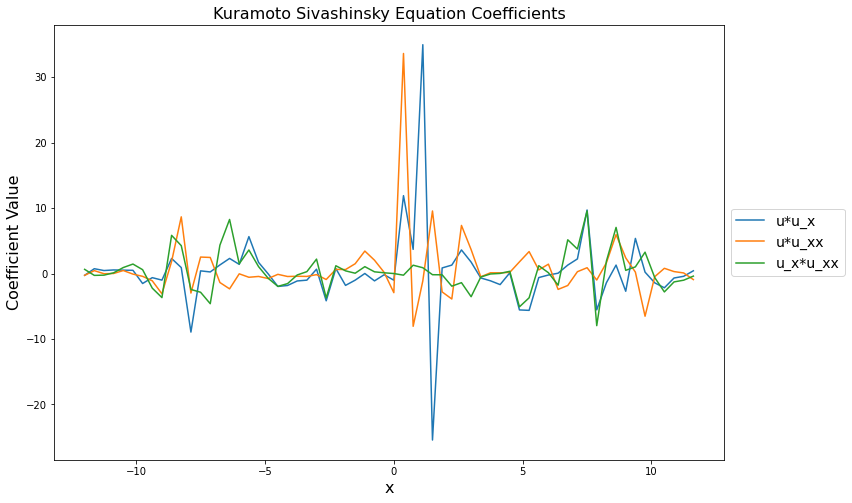

In [48]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 20:
        plot(x, xi[j,:], label = poly_feature_names[j])
        
title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

In [15]:
u_pred = pinn(*dimension_slicing(X_star))[0]

In [49]:
((Exact[:, -64:]-u_pred.reshape(X.shape).T[:, -64:].detach().numpy())**2).mean()

5.278602391712794e-06

In [17]:
dx = x[1]-x[0]
dt = t[1]-t[0]

In [25]:
Z, E1 = RobustPCA(Exact)

Please ensure that the shape of U is correct.
iteration:1, err:11633.945320514831, nc_norm:8.265897069309144 eta1:0.02588635501871843
iteration:50, err:218.1443202108516, nc_norm:27.234058075926832 eta1:2.7625648123581352
iteration:100, err:1.8582753190222592, nc_norm:0.21772835372684118 eta1:324.2998394581583
iteration:150, err:0.015829825024612786, nc_norm:0.0019585764701149175 eta1:38069.83474274163
iteration:200, err:0.00013484721966134714, nc_norm:1.5781006856698823e-05 eta1:4469050.3694395125
iteration:219, err:8.548323817063973e-06, nc_norm:2.1162524854523258e-07 eta1:27332305.576307207


In [18]:
weight = 0
consider = weight*Exact[:, -64:]+(1-weight)*u_pred.reshape(X.shape).T[:, -64:].detach().numpy()

In [57]:
# Ut_ref, Theta_ref, rhs_des = build_linear_system(consider, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'Fourier')
Ut_ref, Theta_ref, rhs_des = build_linear_system(noisy(Exact[:, -64:]), dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'Fourier')

/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_ks/../parametric_pde_diff.py:305: ComplexWarning: Casting complex values to real discards the imaginary part
  elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(u[:,i]))


In [58]:
Theta_grouped = [real(Theta_ref[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(Ut_ref[n*np.arange(m)+j]) for j in range(n)]

/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_ks/../parametric_pde_diff.py:609: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_ks/../parametric_pde_diff.py:579: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))



u
uu_{x}
u_{xx}
u_{xxx}


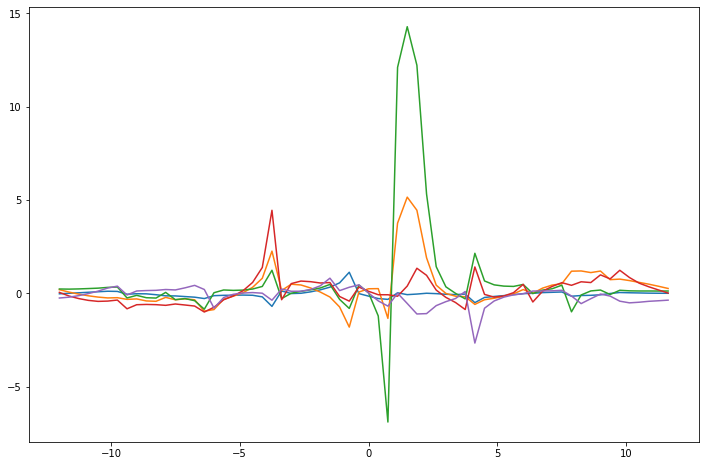

In [59]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, num_tols=50, lam=1e-6)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]):
    if np.linalg.norm(xi[j,:]) > 1e-10:
        print(rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])

In [56]:
def noisy(mm): return mm + 0.00001*np.random.rand(mm.shape[0], mm.shape[1])

In [61]:
((Exact-noisy(Exact))**2).mean()

3.2900802212240995e-11